# Visualizing Performance Summary for Cell Health Target Variables

**Gregory Way, 2019**

For both binary and regression models.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(ggpmisc))

## Load Data

In [2]:
results_dir <- "results"

In [3]:
# Regression Results
regression_file <- file.path(results_dir, "full_cell_health_regression_results.tsv.gz")
regression_metrics_df <- readr::read_tsv(regression_file, col_types = readr::cols())

# Classification Results
roc_file <- file.path(results_dir, "full_cell_health_roc_results.tsv.gz")
full_roc_df <- readr::read_tsv(roc_file, col_types = readr::cols())

pr_file <- file.path(results_dir, "full_cell_health_pr_results.tsv.gz")
full_pr_df <- readr::read_tsv(pr_file, col_types = readr::cols())

# Model Coefficients
coef_file <- file.path(results_dir, "full_cell_health_coefficients.tsv.gz")
full_coef_df <- readr::read_tsv(coef_file, col_types = readr::cols()) %>%
    dplyr::filter(y_transform %in% c("raw", "zero-one"))

# Model Predictions
y_file <- file.path(results_dir, "full_cell_health_y_labels.tsv.gz")
y_df <- readr::read_tsv(y_file, col_types = readr::cols()) %>%
    dplyr::filter(y_transform %in% c("raw", "zero-one"))

# Annotated Cell Health Features
feat_file <- file.path("..", "0.generate-profiles", "data", "labels", "feature_mapping_annotated.csv")
label_df <- readr::read_csv(feat_file, col_types = readr::cols())

## Process Data

In [4]:
regression_subset_df <- regression_metrics_df %>%
    dplyr::filter(y_transform == "raw",
                  data_fit == "test",
                  shuffle == "shuffle_false") %>%
    tidyr::spread(key = "metric", value = "mse") %>%
    dplyr::select(-y_transform)

print(dim(regression_subset_df))
head(regression_subset_df, 3)

[1] 70  5


target,data_fit,shuffle,mse,r_two
<chr>,<chr>,<chr>,<dbl>,<dbl>
cc_all_high_n_spots_h2ax_mean,test,shuffle_false,0.3862278,0.04049796
cc_all_large_notround_polynuclear_mean,test,shuffle_false,0.4526556,0.54528358
cc_all_large_round_polyploid_mean,test,shuffle_false,0.3366414,0.49914908


In [5]:
auroc_df <- full_roc_df %>%
    dplyr::distinct(metric, target, auc, data_fit,
                    shuffle, y_transform, min_class_count)

aupr_df <- full_pr_df %>%
    dplyr::distinct(metric, target, auc, data_fit,
                    shuffle, y_transform, min_class_count)

auc_df <- dplyr::bind_rows(auroc_df, aupr_df) %>%
    dplyr::filter(shuffle == "shuffle_false",
                  data_fit == "test")

auc_df$metric <- dplyr::recode_factor(
    auc_df$metric,
    "roc" = "AUROC",
    "aupr" = "AUPR"
)

auc_df <- auc_df %>%
    tidyr::spread(key = "metric", value = "auc") %>%
    dplyr::select(-y_transform)

print(dim(auc_df))
head(auc_df, 2)

Warning message:
“The `printer` argument is deprecated as of rlang 0.3.0.
This warning is displayed once per session.”

[1] 68  6


target,data_fit,shuffle,min_class_count,AUROC,AUPR
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
cc_all_high_n_spots_h2ax_mean,test,shuffle_false,151,0.7750343,0.7919861
cc_all_large_notround_polynuclear_mean,test,shuffle_false,151,0.5226337,0.5404478


In [6]:
metric_df <- regression_subset_df %>%
    dplyr::inner_join(auc_df, by=c("target", "data_fit", "shuffle")) %>%
    dplyr::left_join(label_df, by=c("target" = "updated_name"))

metric_df$mse = abs(metric_df$mse)

metric_df$maria_thumbs_up <- tidyr::replace_na(metric_df$maria_thumbs_up, 0)
metric_df$measurement <- tidyr::replace_na(metric_df$measurement, "other")

metric_df$measurement <- factor(metric_df$measurement,
                                levels = c("apoptosis", "death", "cell_viability", "toxicity", "dna_damage",
                                           "cell_cycle_arrest", "g1_arrest", "g2_arrest", "g2_m_arrest",
                                           "s_arrest", "other"))
print(dim(metric_df))
head(metric_df, 3)

Warning message:
“`chr_along()` is deprecated as of rlang 0.2.0.
This warning is displayed once per session.”

[1] 68 13


target,data_fit,shuffle,mse,r_two,min_class_count,AUROC,AUPR,original_name,feature_type,measurement,maria_thumbs_up,description
<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<chr>
cc_all_high_n_spots_h2ax_mean,test,shuffle_false,0.3862278,0.04049796,151,0.7750343,0.7919861,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,dna_damage,0,Within all cells: fraction of cells containing more than 3 gH2AX spots
cc_all_large_notround_polynuclear_mean,test,shuffle_false,0.4526556,0.54528358,151,0.5226337,0.5404478,ALL - large not round (polynuclear) - Mean per Well,cell_cycle,toxicity,0,Fraction of cells with large non-round nuclei
cc_all_large_round_polyploid_mean,test,shuffle_false,0.3366414,0.49914908,151,0.6351166,0.7209584,ALL - Large round (polyploid) - Mean per Well,cell_cycle,other,0,NA


## Plot Performance

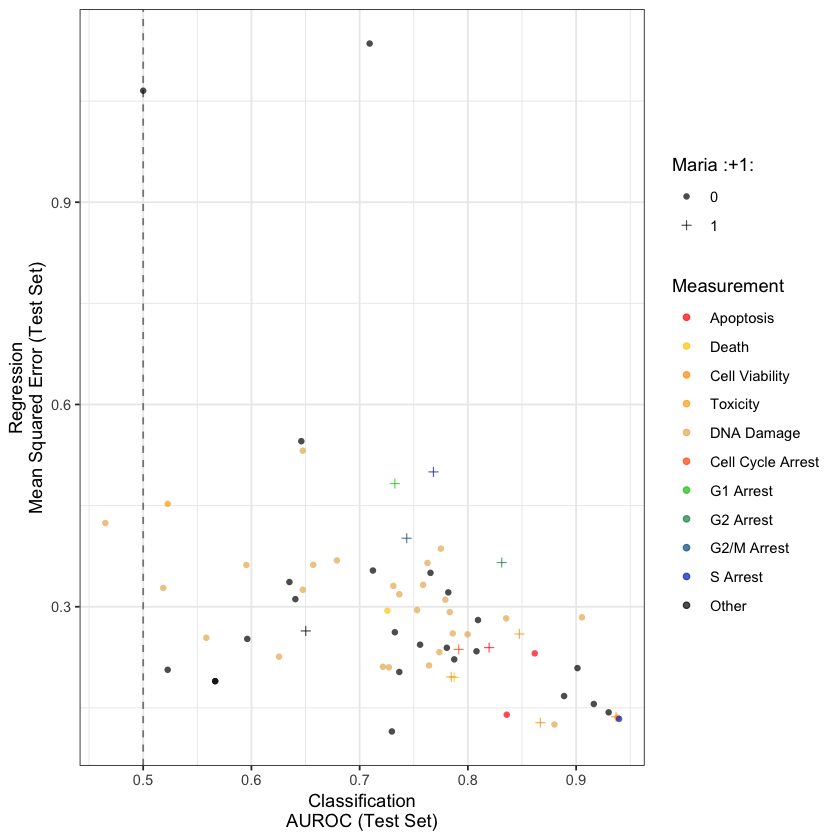

In [7]:
ggplot(metric_df, aes(x = AUROC, y = mse)) +
    geom_point(alpha = 0.7,
               aes(color = measurement,
                   shape = as.factor(maria_thumbs_up))) +
    xlab("Classification\nAUROC (Test Set)") +
    ylab("Regression\nMean Squared Error (Test Set)") +
    geom_vline(xintercept = 0.5,
               alpha = 0.5, 
               linetype = "dashed") +
    scale_shape_manual(name = "Maria :+1:",
                       values = c(16, 3)) +
    scale_color_manual(name = "Measurement",
                       values = c("apoptosis" = "#ff0000",
                                  "cell_cycle_arrest" = "#ff5900",
                                  "cell_viability" = "#ff9900",
                                  "death" = "#ffcc00",
                                  "dna_damage" = "#E8B360", 
                                  "g1_arrest" = "#00c20d",
                                  "g2_arrest" = "#008f4c",
                                  "g2_m_arrest" = "#005c8c",
                                  "other" = "black",
                                  "s_arrest" = "#0033bf",
                                  "toxicity" = "#feab00"),
                       labels = c("apoptosis" = "Apoptosis",
                                  "cell_cycle_arrest" = "Cell Cycle Arrest",
                                  "cell_viability" = "Cell Viability",
                                  "death" = "Death",
                                  "dna_damage" = "DNA Damage", 
                                  "g1_arrest" = "G1 Arrest",
                                  "g2_arrest" = "G2 Arrest",
                                  "g2_m_arrest" = "G2/M Arrest",
                                  "other" = "Other",
                                  "s_arrest" = "S Arrest",
                                  "toxicity" = "Toxicity")) +
    theme_bw()

file <- file.path("figures", "performance_summary.png")
ggsave(file, dpi = 300, width = 6, height = 4.5)